In [29]:
import pandas as pd
import sklearn
import numpy as np

df = pd.read_csv('data/haystacks_ga_clean_new_format.csv').drop_duplicates()
groups = df.groupby('county')['zipcode'].apply(list)
zipcount = pd.Series([], dtype='O')
for zipcode in sorted(set(df.zipcode.values)):
    zipcount[zipcode] = [county for county in set(df.county.values) if zipcode in (groups[county])]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9685 entries, 0 to 10312
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitude                  9685 non-null   float64
 1   longitude                 9685 non-null   float64
 2   address                   9685 non-null   object 
 3   city                      9685 non-null   object 
 4   county                    9685 non-null   object 
 5   state                     9685 non-null   object 
 6   zipcode                   9685 non-null   int64  
 7   listing_status            9685 non-null   int64  
 8   details                   9685 non-null   object 
 9   square_footage            9685 non-null   float64
 10  overall_crime_grade       9685 non-null   object 
 11  ES_rating                 9685 non-null   float64
 12  caprate                   9685 non-null   float64
 13  lot_size                  9685 non-null   float64
 14  baths_h

In [31]:
## Mask for turning crime grades into integers. Will eventually put this in data preprocessing.
mask = {'F': 0,
       'D-': 1,
       'D': 2,
       'D+': 3,
       'C-': 4,
       'C': 5,
       'C+': 6,
       'B-': 7,
       'B': 8,
       'B+': 9,
       'A-': 10,
       'A': 11}
df['overall_crime_grade'] = df['overall_crime_grade'].apply(lambda row: mask[row])
df['property_crime_grade'] = df['property_crime_grade'].apply(lambda row: mask[row])
df = df.drop(['details', 
              'special_features',   
              'state',  
              'rent',
              'caprate',
              'address',
              'longitude',
              'latitude',
              'address',
              'city'], axis=1)
df.head()

,county,zipcode,listing_status,square_footage,overall_crime_grade,ES_rating,lot_size,baths_half,MS_rating,HS_rating,listing_special_features,beds,price,baths_full,year_built,property_crime_grade,transaction_type
0,Brooks,31643,1,1460.0,1,1.000000,0.0,0.0,2.0,2.5,0,3.0,99000,1.0,1910.0,1,1
2,Camden,31548,1,1618.0,7,7.333333,0.0,0.0,6.0,8.0,0,3.0,200000,2.0,1986.0,6,1
3,Camden,31548,1,2103.0,7,7.333333,0.0,0.0,6.0,8.0,2,4.0,339900,2.0,2020.0,6,1
4,Camden,31548,1,2954.0,7,7.333333,0.0,0.0,6.0,8.0,0,4.0,679900,3.0,2019.0,6,1
5,Camden,31548,1,1648.0,7,7.333333,0.0,0.0,6.0,8.0,0,3.0,279000,2.0,1994.0,6,1


In [56]:
pd.set_option('display.max_rows', 100)
df.county.value_counts()

Fulton        1193
Gwinnett       860
DeKalb         699
Cobb           569
Henry          341
              ... 
Mitchell         1
McDuffie         1
Jeff-Davis       1
Jefferson        1
Brooks           1
Name: county, Length: 138, dtype: int64

In [33]:
## Below will be a template for other models. The intent is for model-agnosticism to inform design.

## We do not have sufficient data to actually justify running a model at every zip code.
## Nevertheless, we will code that up, as it will be simple to apply to a subset of zips.

## We should look into grouping smaller zip codes if relevant.

## Import necessary models/tools

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import shap
import pickle

In [6]:
# ## creates dataframe for each zipcode
# zip_dfs=[]
# for zipcode in sorted(set(df.zipcode.values)):
#     zip_dfs.append((df.loc[df.zipcode==zipcode,:], zipcode)
#                   )
    
    
    
# ## list for models
# models = []

# ## list for shap values and explainers
# shaps = []
# ziplist = []


# for zdf in zip_dfs:
    
#     X = zdf[0].drop(['price',
#                      'zipcode',
#                      "latitude",
#                      'longitude', 
#                      'city', 
#                      'address'], axis=1)

#     y = zdf[0][['price']]
    
#     if len(zdf[0]) == 1:
#         X_train = X
#         y_train = y
        
#     else:
#         X_train, X_test, y_train, y_test = train_test_split(
#             X, 
#             y,
#             train_size = 0.8,
#             random_state = 0)
#     models.append((LinearRegression().fit(X_train, y_train), zdf[1]))
    
#     explainer = shap.Explainer(models[-1][0], zdf[0].drop)
#     shap_values = explainer(X)
#     shaps.append([explainer, shap_values, zdf[1]])
    
    

In [47]:
## creates dataframe for each zip code
zip_dfs=pd.Series([], dtype='O')

for zipcode in sorted(set(df.zipcode.values)):
    zip_dfs[zipcode] = (df.loc[df.zipcode==zipcode,:], zipcode)
                  
## creates dataframe of all counties intersecting a specific zip code
zipcount_dfs = pd.Series([], dtype='O')
for zipcode in sorted(set(df.zipcode.values)):
    zipcount_dfs[zipcode] = df.loc[df.county.isin(zipcount[zipcode]),:]
    
    
## list for models
models = []

## list for shap values and explainers
shaps = []
ziplist = []


for zdf in zip_dfs:
    
    X = zipcount_dfs[zdf[1]].drop(['price',
                     'county', 
                     'zipcode'],
                    axis=1)

    y = zipcount_dfs[zdf[1]][['price']]
    
    if len(zipcount_dfs[zdf[1]]) == 1:
        X_train = X
        y_train = y
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
    models.append((LinearRegression().fit(X_train, y_train), zdf[1]))
    
    explainer = shap.Explainer(models[-1][0], zipcount_dfs[zdf[1]].drop(columns = ['price', 'county', 'zipcode']))
    shap_values = explainer(zdf[0].drop(columns = ['price', 'county', 'zipcode']))
    shaps.append([explainer, shap_values, zdf[1]])

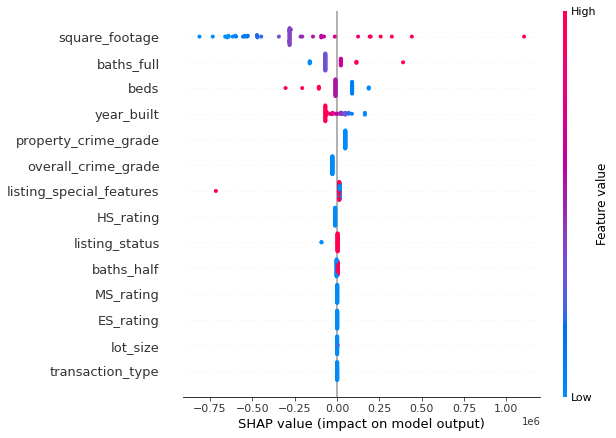

In [48]:
## a sample plot
shap.plots.beeswarm(shaps[5][1], max_display = None)

In [9]:
## OLD

# filename = 'linear_models.sav'
# pickle.dump(models, open(filename, 'wb'))

In [10]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

In [11]:
MS_df = mod_ser.merge(sv_ser, on='zipcode')
MS_df = MS_df.merge(exp_ser, on='zipcode')
MS_df.index = MS_df.zipcode

## The below can be taken out if desired.
MS_df = MS_df.drop(['zipcode'], axis=1)

In [12]:
## Can't print MS_df['shap_values'], but the column is there.

In [13]:
# filename = 'MLR_modNshap.P'
# pickle.dump(models, open(filename, 'wb'))

In [14]:
from sklearn.linear_model import LassoCV
df1 = pd.read_csv('data/haystacks_ga_clean_new_format.csv').drop_duplicates()
## Mask for turning crime grades into integers. Will eventually put this in data preprocessing.
mask = {'F': 0,
       'D-': 1,
       'D': 2,
       'D+': 3,
       'C-': 4,
       'C': 5,
       'C+': 6,
       'B-': 7,
       'B': 8,
       'B+': 9,
       'A-': 10,
       'A': 11}
df1['overall_crime_grade'] = df1['overall_crime_grade'].apply(lambda row: mask[row])
df1['property_crime_grade'] = df1['property_crime_grade'].apply(lambda row: mask[row])

In [15]:
#### Total Georgia example (might use to stack latter)
X_train, X_test, y_train, y_test = train_test_split(
            df1.drop(columns = ['price', 
                                'county', 
                                'zipcode', 
                                #'listing_special_features', 
                                #'listing_status', 
                                #'transaction_type',
                                'details', 
                                #'special_features',   
                                'state',  
                                #'rent',
                                'caprate',
                                'address',
                                'longitude',
                                'latitude',
                                'address',
                                'city']
                    ), 
            df1.price,
            train_size = 0.8,
            random_state = 0)
model=LassoCV().fit(X_train, y_train)
model.score(X_test,y_test)

0.39129509219680103

In [16]:
### very bad... Might be best to group regionally in the future or urban vs rural. Should standardize too.

In [25]:
################ Quick check at random forest performance
from sklearn.ensemble import RandomForestRegressor
                            
X_train, X_test, y_train, y_test = train_test_split(
            df1.drop(columns = ['price', 
                                'county', 
                                'zipcode', 
                                'listing_special_features', 
#                                 'listing_status', 
                                'transaction_type',
                                'details', 
                                #'special_features',   
                                'state',  
                                'rent',
                                'caprate', ## comment out to make data leakage go brrr
                                'address',
                                'longitude',
                                'latitude',
                                'address',
                                'city']
                    ), 
            df1.price,
            train_size = 0.8,
            random_state = 0)
model=RandomForestRegressor(random_state=0).fit(X_train, y_train)
model.score(X_test,y_test)                            

0.6154737018626767

In [26]:
# Try XGB too
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


model = GradientBoostingRegressor(random_state=0).fit(X_train, np.ravel(y_train))
model.score(X_test,y_test) 

0.6696986128264695

In [58]:
df1.sort_values(by='price', ascending = False).head(100)

,latitude,longitude,address,city,county,state,zipcode,listing_status,details,square_footage,...,HS_rating,listing_special_features,rent,beds,special_features,price,baths_full,year_built,property_crime_grade,transaction_type
796,32.945222,-83.817387,5327 U S 41,MacOn,Monroe,Georgia,31210,1,"Detached, 7 Beds, 8+ Baths, 329.00 Acres",2980.962963,...,6.000000,0,2225.040125,7.0,0,45250000,8.0,2002.0,2,1
453,33.877570,-83.731971,0 George Williams Road,Monroe,Walton,Georgia,30656,1,"Detached, 12 Beds, 12+ Baths, 27,808 Sq Ft",27808.000000,...,5.000000,0,7060.224767,12.0,0,19800000,12.0,2018.0,5,1
452,33.874729,-83.729923,3084 George Williams Road,Monroe,Walton,Georgia,30656,1,"Detached, 12 Beds, 12+ Baths, 27,808 Sq Ft",27808.000000,...,5.000000,0,7060.224767,12.0,0,19800000,12.0,2018.0,5,1
10020,34.843967,-83.719654,7320 Chestnut Valley Road,Hiawassee,Towns,Georgia,30546,1,"Detached, 6 Beds, 6 Baths, 457.00 Acres",1950.782609,...,7.000000,0,1803.890000,6.0,0,15000000,6.0,1889.0,5,1
5654,34.249393,-84.052846,5325 Browns Bridge Road,Cumming,Forsyth,Georgia,30041,1,"Detached, 3 Beds, 2½ Baths, 2,241 Sq Ft",2241.000000,...,9.000000,0,1890.000000,3.0,0,13500000,2.0,1972.0,7,1
5655,34.248541,-84.054929,0 Browns Bridge Road #9004867,Cumming,Forsyth,Georgia,30041,1,"Detached, 3 Beds, 2½ Baths, 54.00 Acres",3689.275362,...,9.000000,0,1890.000000,3.0,0,13500000,2.0,1972.0,7,1
6512,33.881702,-84.425369,4750 Northside Drive NW,Atlanta,Fulton,Georgia,30327,1,"Detached, 6 Beds, 6+ Baths, 14,450 Sq Ft",14450.000000,...,7.000000,2,3052.330000,6.0,2,11995000,6.0,2022.0,5,1
6496,33.852061,-84.454369,3500 Riverly Road NW,Atlanta,Fulton,Georgia,30327,1,"Detached, 8 Beds, 10+ Baths, 5.09 Acres",6357.607843,...,7.000000,0,4036.706425,8.0,0,10950000,10.0,2000.0,5,1
6525,33.843723,-84.451637,2518 W Wesley Road NW,Atlanta,Fulton,Georgia,30327,1,"Detached, 9 Beds, 9+ Baths, 11.00 Acres",6357.607843,...,7.000000,2,4642.212389,9.0,2,10900000,9.0,2022.0,5,1
6524,33.845482,-84.452194,1950 W Paces Ferry Road NW,Atlanta,Fulton,Georgia,30327,1,"Detached, 9 Beds, 9+ Baths, 11.00 Acres",6357.607843,...,7.000000,2,4642.212389,9.0,2,10900000,9.0,2022.0,5,1
